# Project Report: Predicting Resale Flat Prices in Singapore

### Problem Statement
The objective of this project is to develop a machine learning model and deploy it as a user-friendly web application that predicts the resale prices of flats in Singapore. This predictive model will be based on historical data of resale flat transactions, and it aims to assist both potential buyers and sellers in estimating the resale value of a flat.

### Motivation
<p> The resale flat market in Singapore is highly competitive, and it can be challenging to accurately estimate the resale value of a flat. There are many factors that can affect resale prices, such as location, flat type, floor area, and lease duration. A predictive model can help to overcome these challenges by providing users with an estimated resale price based on these factors. </p>

### Steps Involved:
1. Data Collection
2. Data Explanation
3. Data Preprocessing
4. Exploratory Data Analysis (EDA)
5. Data Handling
6. Feature Engineering
7. Train and Test Split
8. Model Selection
9. Model Training
10. Model Evaluation
11. Best Model Selection and Explanation
12. Feature Importance
13. Creating a Streamlit App

### Libraries
    Pandas: For data manipulation and analysis.
    NumPy: For numerical computations.
    Matplotlib: For data visualization.
    Seaborn: For statistical data visualization.
    Scikit-learn: For machine learning algorithms and evaluation metrics.
    Streamlit: For building the web application.
    Joblib: For saving and loading machine learning models.

## Complete Project Code

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from math import sqrt

### Step 1: Data Collection

In [12]:
file_paths = [
    'files\ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv',
    'files\ResaleFlatPricesBasedonApprovalDate19901999.csv',
    'files\ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv',
    'files\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv',
    'files\ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv'
]

dfs = [pd.read_csv(file) for file in file_paths]


### Step 2: Data Explanation
We read and inspect the first few rows of each dataset to understand its structure.

In [13]:
for i, df in enumerate(dfs):
    print(f"Dataset {i+1} - First 5 rows:")
    print(df.head())
    print("\n")


Dataset 1 - First 5 rows:
     month        town flat_type block       street_name storey_range  \
0  2000-01  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09   
1  2000-01  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06   
2  2000-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     07 TO 09   
3  2000-01  ANG MO KIO    3 ROOM   215  ANG MO KIO AVE 1     07 TO 09   
4  2000-01  ANG MO KIO    3 ROOM   218  ANG MO KIO AVE 1     07 TO 09   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            69.0        Improved                 1986      147000.0  
1            61.0        Improved                 1986      144000.0  
2            73.0  New Generation                 1976      159000.0  
3            73.0  New Generation                 1976      167000.0  
4            67.0  New Generation                 1976      163000.0  


Dataset 2 - First 5 rows:
     month        town flat_type block       street_name storey_range  \
0  1990-

### Step 3: Data Preprocessing
Cleaning and merging datasets.

In [14]:
if 'remaining_lease' in dfs[4].columns:
    dfs[4]['remaining_lease'] = dfs[4]['remaining_lease'].str.split(' ').str[0].astype('int64')

df_combined = pd.concat(dfs, ignore_index=True)


### Step 4: Exploratory Data Analysis (EDA)
Performing basic statistics and visualizations.

       floor_area_sqm  lease_commence_date  resale_price
count   930130.000000        930130.000000  9.301300e+05
mean        95.689298          1988.307170  3.216994e+05
std         25.820070            10.695315  1.713318e+05
min         28.000000          1966.000000  5.000000e+03
25%         73.000000          1981.000000  1.940000e+05
50%         93.000000          1986.000000  2.980000e+05
75%        113.000000          1996.000000  4.188880e+05
max        307.000000          2020.000000  1.588000e+06


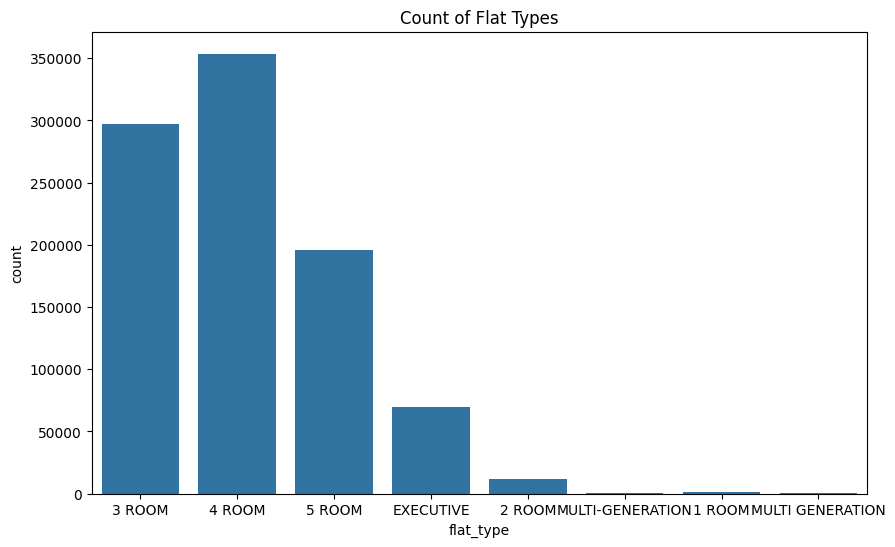

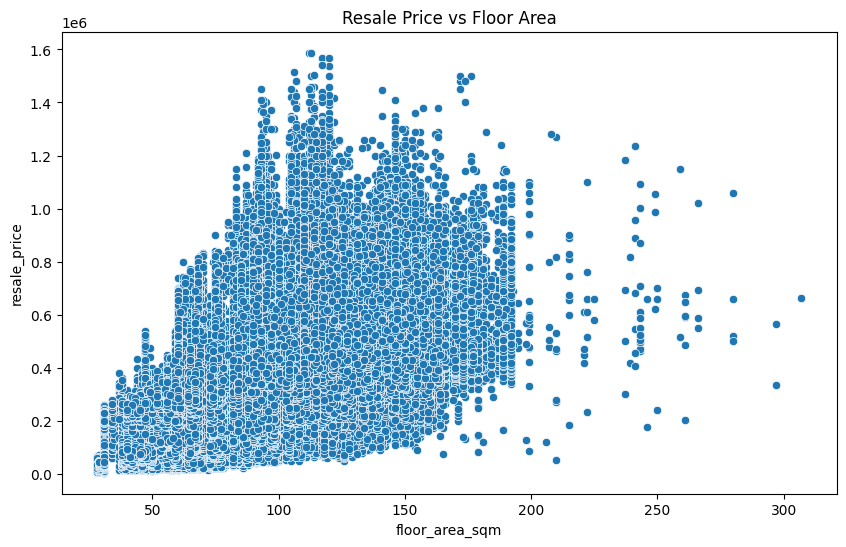

In [15]:
print(df_combined.describe())

plt.figure(figsize=(10, 6))
sns.countplot(x='flat_type', data=df_combined)
plt.title('Count of Flat Types')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=df_combined)
plt.title('Resale Price vs Floor Area')
plt.show()


### Step 5: Data Handling
Handling missing values and data inconsistencies.

In [16]:
df_combined[['year', 'month']] = df_combined['month'].str.split('-', expand=True)
df_combined['year'] = pd.to_numeric(df_combined['year'])
df_combined['month'] = pd.to_numeric(df_combined['month'])
df_combined['remaining_lease'] = pd.to_numeric(df_combined['remaining_lease'], errors='coerce')
df_combined['remaining_lease'].fillna(99 - (df_combined['year'] - df_combined['lease_commence_date']), inplace=True)


C:\Users\abhir\AppData\Local\Temp\ipykernel_16912\108020835.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['remaining_lease'].fillna(99 - (df_combined['year'] - df_combined['lease_commence_date']), inplace=True)


In [17]:
# Standardize categorical values
df_combined['flat_model'] = df_combined['flat_model'].str.upper()
df_combined['flat_type'] = df_combined['flat_type'].str.lower()
type_mapping = {
    '1 room': '1 room', '3 room': '3 room', '4 room': '4 room', '5 room': '5 room',
    '2 room': '2 room', 'executive': 'executive', 'multi generation': 'multi generation',
    'multi-generation': 'multi generation'
}
df_combined['flat_type'] = df_combined['flat_type'].map(type_mapping).str.upper()

# Convert 'remaining_lease' to numeric
df_combined['remaining_lease'] = pd.to_numeric(df_combined['remaining_lease'], errors='coerce')
df_combined = df_combined[df_combined['remaining_lease'] <= 99]

# Split 'storey_range' into lower and upper bounds
df_combined[['lower_bound', 'upper_bound']] = df_combined['storey_range'].str.split(' TO ', expand=True)
df_combined['lower_bound'] = pd.to_numeric(df_combined['lower_bound'])
df_combined['upper_bound'] = pd.to_numeric(df_combined['upper_bound'])

# Add new columns
df_combined['price_per_sqm'] = df_combined['resale_price'] / df_combined['floor_area_sqm']
df_combined['years_holding'] = df_combined['year'] - df_combined['lease_commence_date']
df_combined['current_remaining_lease'] = df_combined['remaining_lease'] - (2024 - df_combined['year'])


### Step 6: Feature Engineering
Creating new features to enhance the model.

In [18]:
selected_columns = ['year', 'town', 'flat_type', 'flat_model', 'storey_range', 
                    'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 
                    'current_remaining_lease', 'years_holding', 'resale_price']
dftrain = df_combined[selected_columns]

# Separate features (X) and target variable (y)
X = dftrain.drop('resale_price', axis=1)
y = dftrain['resale_price']

### Step 7: Train and Test Split
Splitting the data into training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Apply OneHotEncoder to categorical features and StandardScaler to numerical features
numeric_features = ['year', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'current_remaining_lease', 'years_holding']
categorical_features = ['town', 'flat_type', 'flat_model', 'storey_range']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


### Step 8: Model Selection
Choosing multiple models for evaluation.

In [20]:
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', LinearRegression())]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', DecisionTreeRegressor(random_state=42))])
}

### Step 9: Model Training
Training the models on the training data.

### Step 10: Model Evaluation
Evaluating the models using various metrics.

In [21]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    return mae, mse, rmse, r2, explained_variance

# Initialize results dictionary
results = {}

In [22]:
# Function to train, evaluate and store results for a each model
def run_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    results[model_name] = evaluate_model(model, X_test, y_test)
    return model

In [23]:
# Run and evaluate each model separately
linear_regression_model = run_model('Linear Regression', models['Linear Regression'], X_train, y_train, X_test, y_test)
linear_regression_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'remaining_lease',
                                                   'current_remaining_lease',
                                                   'years_holding']),
                                                 ('cat', OneHotEncoder(),
                                                  ['town', 'flat_type',
                                                   'flat_model',
                                                   'storey_range'])])),
                ('model', LinearRegression())])

In [24]:
decision_tree_model = run_model('Decision Tree', models['Decision Tree'], X_train, y_train, X_test, y_test)
decision_tree_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'remaining_lease',
                                                   'current_remaining_lease',
                                                   'years_holding']),
                                                 ('cat', OneHotEncoder(),
                                                  ['town', 'flat_type',
                                                   'flat_model',
                                                   'storey_range'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [25]:
# Display results
results_df = pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'R2 Score', 'Explained Variance'])
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
                    Linear Regression  Decision Tree
MAE                      5.233103e+04   2.058028e+04
MSE                      4.693861e+09   9.460330e+08
RMSE                     6.851176e+04   3.075765e+04
R2 Score                 8.410805e-01   9.679703e-01
Explained Variance       8.410820e-01   9.679706e-01


### Step 11: Best Model Selection and Explanation
Selecting the best model based on R2 Score.

In [26]:
best_model_name = results_df.loc['R2 Score'].idxmax()
best_model = models[best_model_name]
print(f"The best model is {best_model_name} with an R2 Score of {results_df.loc['R2 Score', best_model_name]}")

The best model is Decision Tree with an R2 Score of 0.9679702649519535


# Save the best model

In [27]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

### Step 12: Feature Importance
Displaying feature importance for the best model if applicable.

In [28]:
if best_model_name in ['Decision Tree']:
    best_model.fit(X_train, y_train)  # Ensure model is trained
    feature_importances = best_model.named_steps['model'].feature_importances_
    feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    print("Feature Importances:")
    print(feature_importances_df)

Feature Importances:
                    Feature    Importance
0                      year  5.283198e-01
1            floor_area_sqm  2.626047e-01
36         flat_type_4 ROOM  5.617593e-02
4   current_remaining_lease  1.688434e-02
2       lease_commence_date  1.607056e-02
..                      ...           ...
75    storey_range_26 TO 30  8.155776e-07
40        flat_model_2-ROOM  3.902504e-07
80    storey_range_36 TO 40  1.183133e-07
59       flat_model_TYPE S1  0.000000e+00
78    storey_range_31 TO 35  0.000000e+00

[86 rows x 2 columns]


In [1]:
import sklearn
print(sklearn.__version__)

1.5.1
